In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

import torch

BATCH_SIZE = 100
EPOCHS = 150
LEARNING_RATE = 3e-2
SEED = 0

In [3]:
!pip3 install datasets

In [4]:
!pip3 install lambeq

In [5]:
!pip3 install discopy

In [6]:
!pip3 install pytket-qiskit

  Using cached pytket_qiskit-0.53.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached qiskit-1.0.2-cp38-abi3-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached qiskit_algorithms-0.3.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached qiskit_ibm_runtime-0.23.0-py3-none-any.whl.metadata (19 kB)
  Using cached qiskit_aer-0.14.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (8.0 kB)
  Using cached qiskit_ibm_provider-0.10.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached stevedore-5.2.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.11.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (1.2 kB)
  Using cached requests_ntlm-1.2.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached ibm_platform_services-0.53.6-py3-none-any.whl
  Using cached ibm_cloud_sdk_core-3.20.0-py3-none-any.whl
  Using cached cryptography-42.0.5-cp39-abi3-macosx_10_12_universal2.whl.metadata (5.3 kB)
  Using cached pyspnego-0.10.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pbr-6.0.0-py2.py3-none-any.whl

Load in the dataset

In [7]:
import pandas as pd

data = pd.read_csv('eng.word.train.tsv', sep='\t')
print(data.head())

dev = pd.read_csv('eng.word.dev.tsv', sep='\t')
print(dev.head())


            Word         Tokenization  Num
0      pentazole    penta @@azo @@ole   10
1  biopatterning  bio @@pattern @@ing  110
2          nyala                nyala    0
3          biots             biot @@s  100
4      balalaika            balalaika    0
             Word             Tokenization  Num
0   enthrallments   en @@thrall @@ment @@s  110
1          incult                   incult    0
2      paskudnyak               paskudnyak    0
3     patronesses         patron @@ess @@s  110
4  monomethylases  mono @@methyl @@ase @@s  110


Load in test, train, and dev data

In [8]:
# Train Data 
print(len(data["Word"]))
print(data["Tokenization"][0])

words = []
tokens = []
len_toks = []
bpe_tokens = []
leng = 0
for i in range(650):
    if type(data["Word"][i]) == str:
        words.append(data["Word"][i])
        token_seq = data["Tokenization"][i].split()
        tokens.append([x.strip("@@") for x in token_seq])
        bpe_tokens.append(' '.join([x.strip("@@") for x in token_seq]))
        len_toks.append(len(token_seq))
        leng += 1
print(words[:5])
print(tokens[:5])
print(bpe_tokens[:5])
print(leng)

458692
penta @@azo @@ole
['pentazole', 'biopatterning', 'nyala', 'biots', 'balalaika']
[['penta', 'azo', 'ole'], ['bio', 'pattern', 'ing'], ['nyala'], ['biot', 's'], ['balalaika']]
['penta azo ole', 'bio pattern ing', 'nyala', 'biot s', 'balalaika']
650


In [9]:
# Dev Data
print(len(dev["Word"]))
print(data["Tokenization"][0])

words_dev = []
tokens_dev = []
len_toks_dev = []
leng_dev = 0
for i in range(78):
    if type(dev["Word"][i]) == str:
        words_dev.append(dev["Word"][i])
        token_seq = dev["Tokenization"][i].split()
        tokens_dev.append([x.strip("@@") for x in token_seq])
        len_toks_dev.append(len(token_seq))
        leng_dev += 1
print(words_dev[:5])
print(tokens_dev[:5])
print(leng_dev)

57371
penta @@azo @@ole
['enthrallments', 'incult', 'paskudnyak', 'patronesses', 'monomethylases']
[['en', 'thrall', 'ment', 's'], ['incult'], ['paskudnyak'], ['patron', 'ess', 's'], ['mono', 'methyl', 'ase', 's']]
78


In [10]:
# Test Data
print(len(dev["Word"]))
print(data["Tokenization"][0])

words_test = []
tokens_test = []
len_toks_test = []
clean_test = []
leng_test = 0
for i in range(700, 785):
    if type(data["Word"][i]) == str:
        words_test.append(data["Word"][i])
        token_seq = data["Tokenization"][i].split()
        tokens_test.append([x.strip("@@") for x in token_seq])
        clean_test.append(" ".join([x.strip("@@") for x in token_seq]))
        len_toks_test.append(len(token_seq))
        leng_test += 1
print(words_test[:5])
print(tokens_test[:5])
print(leng_test)

57371
penta @@azo @@ole
['biclosed', 'plurified', 'exigendaries', 'anticultures', 'pseudomythological']
[['bi', 'close', 'ed'], ['plurify', 'ed'], ['exigendary', 's'], ['anti', 'culture', 's'], ['pseudo', 'myth', 'ology', 'ical']]
85


Load in Models

Import sentencepiece and train model (https://github.com/google/sentencepiece)

In [11]:
!pip3 install sentencepiece

In [12]:
import sentencepiece as spm

lang = "eng"
vocab_size=412

eng_train_scr = open("eng.train.src", "w")
for word in words:
  eng_train_scr.write(f"{word}\n")
eng_train_scr.close()

eng_train_tgt = open("eng.train.tgt", "w")
for word in bpe_tokens:
  eng_train_tgt.write(f"{word}\n")
eng_train_tgt.close()


train_file = f'{lang}.train.src'

spm.SentencePieceTrainer.Train(
    input=train_file,
    model_prefix=f'unigram_{lang}',
    vocab_size=vocab_size,
    model_type='unigram'
)

s_model = spm.SentencePieceProcessor(model_file=f'unigram_{lang}.model')

preds_sent = []

for word in words_test:
  pred = ' '.join(s_model.encode(word, out_type=str))[1:].lstrip()
  preds_sent.append(pred)

print(preds_sent[:10])

['b i clo s ed', 'p l ur ifi ed', 'ex i g en d a ri es', 'anti c ul t ur es', 'pseudo m y t hol o g ic al', 's c or eth', 'c an t al o u p e y', 'ap p re s s ion', 'd i v ul s ing', 'b i f a ce t ed']


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: eng.train.src
  input_format: 
  model_prefix: unigram_eng
  model_type: UNIGRAM
  vocab_size: 412
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  di

Load in Morfessor (https://morfessor.readthedocs.io/en/latest/)

In [13]:
!pip3 install morfessor

In [14]:
import morfessor

lang = "eng"

train_file = f'{lang}.train.src'

io = morfessor.MorfessorIO()
data = list(io.read_corpus_file(train_file))
model_morph = morfessor.BaselineModel()
model_morph.load_data(data)
model_morph.train_batch()
io.write_binary_file(f'morfessor_{lang}.model', model_morph)

...........................................................
................

...........................................


In [15]:
model = io.read_binary_model_file(f'morfessor_{lang}.model')

preds_morph = []

for word in words_test:
    pred = " ".join(model_morph.viterbi_segment(word)[0]).strip()
    preds_morph.append(pred)

print(preds_morph[:10])

['biclosed', 'plurified', 'exigendaries', 'anticultures', 'pseudomythological', 'scoreth', 'cantaloupey', 'appression', 'divulsing', 'bifaceted']


Load in BPE (https://huggingface.co/learn/nlp-course/en/chapter6/8?fw=pt)

In [16]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.BPE())

# Step 1: Pre-tokenization
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space = False)

# Step 2: Instantiate the trainer
trainer = trainers.BpeTrainer(vocab_size=412, special_tokens=["<|endoftext|>"])

# Step 3: Train the model
with open("training_data.txt", "w", encoding="utf-8") as f:
  for i in range(len(bpe_tokens)):
    target = []
    target = bpe_tokens[i].split()
    for morph in target:
      f.write(morph + "\n")

tokenizer.model = models.BPE()
tokenizer.train(["training_data.txt"], trainer = trainer)
# tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

# Step 4: Test the Tokenizer
encoding = tokenizer.encode("aftertimes")
print(encoding.tokens)

temp_bpe = []
for word in words_test: 
  encoding = tokenizer.encode(word)
  temp_bpe.append(encoding.tokens)

preds_bpe = []
for word in temp_bpe:
  preds_bpe.append(' '.join(word))

# Step 5: Post-processing/Re-formatting
tokenizer.post_processor = processors.ByteLevel(trim_offsets = False)

print(preds_bpe[:10])


['af', 'ter', 'ti', 'me', 's']
['b ic lo s ed', 'pl ur i f i ed', 'ex ig en d ar ie s', 'an t icul tu re s', 'pseudo my th o lo g ic al', 'sco re th', 'c an t al ou pe y', 'ap pre ss ion', 'di v ul s ing', 'bi f ac et ed']




Break Data into Correct or Incorrect Sets
- correct: leave alone
- wrong_sep: change separation schema randomly
- no_sep: take a separated word and make it into one word

In [17]:
# Train Data
import random
correct = []
no_sep = []
wrong_sep = []
for i in range(leng):
    if len(tokens[i]) > 1:
        r = random.randint(1, 3)
        match r:
            case 1:
                correct.append(i)
            case 2:
                no_sep.append(i)
            case 3:
                wrong_sep.append(i)
            case _:
                pass
    else:
        correct.append(i)
print(len(correct))
print(len(no_sep))
print(len(wrong_sep))
print(correct[:10])
print(no_sep[:10])
print(wrong_sep[:10])
print(len(correct) + len(no_sep) + len(wrong_sep) == leng)
print(max(len_toks))

285
186
179
[2, 4, 7, 8, 9, 13, 14, 15, 21, 24]
[3, 5, 11, 16, 17, 18, 19, 23, 27, 28]
[0, 1, 6, 10, 12, 20, 22, 26, 30, 33]
True
6


In [18]:
# Dev Data
import random
correct_dev = []
no_sep_dev = []
wrong_sep_dev = []
for i in range(leng_dev):
    if len(tokens_dev[i]) > 1:
        r = random.randint(1, 3)
        match r:
            case 1:
                correct_dev.append(i)
            case 2:
                no_sep_dev.append(i)
            case 3:
                wrong_sep_dev.append(i)
            case _:
                pass
    else:
        correct_dev.append(i)
print(len(correct_dev))
print(len(no_sep_dev))
print(len(wrong_sep_dev))
print(correct_dev[:10])
print(no_sep_dev[:10])
print(wrong_sep_dev[:10])
print(len(correct_dev) + len(no_sep_dev) + len(wrong_sep_dev) == leng_dev)
print(max(len_toks_dev))

30
22
26
[0, 1, 2, 3, 4, 5, 7, 8, 10, 13]
[6, 9, 12, 15, 17, 22, 24, 27, 28, 32]
[11, 21, 23, 29, 31, 33, 35, 41, 43, 46]
True
4


In [19]:
# Test Data
import random
correct_test = []
no_sep_test = []
wrong_sep_test = []
for i in range(leng_test):
    if len(tokens_test[i]) > 1:
        r = random.randint(1, 3)
        match r:
            case 1:
                correct_test.append(i)
            case 2:
                no_sep_test.append(i)
            case 3:
                wrong_sep_test.append(i)
            case _:
                pass
    else:
        correct_test.append(i)
print(len(correct_test))
print(len(no_sep_test))
print(len(wrong_sep_test))
print(correct_test[:10])
print(no_sep_test[:10])
print(wrong_sep_test[:10])
print(len(correct_test) + len(no_sep_test) + len(wrong_sep_test) == leng_test)
print(max(len_toks_test))

39
23
23
[0, 3, 8, 10, 12, 15, 18, 19, 21, 29]
[1, 2, 11, 17, 22, 23, 24, 27, 28, 30]
[4, 5, 6, 7, 9, 13, 14, 16, 20, 25]
True
5


Make the alterations for bad examples

In [20]:
# Train Data
for i in no_sep:
    old_tok = tokens[i]
    new_str = "".join(old_tok)
    tokens[i] = [new_str]

for j in wrong_sep:
    old_tok = tokens[j]
    #print("old_tok:", old_tok)
    new_break = []
    len_ot = len(old_tok)
    rand1 = random.randint(0, len_ot-1)
    if len_ot > 1:
        rand2 = rand1
        while rand2 == rand1:
            rand2 = random.randint(0, len_ot-1)
        maxx = max(rand1, rand2)
        minn = min(rand1, rand2)
       #print("minn, maxx: ", minn, maxx)
        add = ""
        for k in range(len_ot):
            if k < minn or k > maxx:
                new_break.append(old_tok[k])
            elif k == maxx:
                add = add+old_tok[k]
                new_break.append(add)
            else:
                add = add+old_tok[k]
                #print("add:", add)  
    else:
        new_break = old_tok 
    #print("new_break:", new_break)
    tokens[i] = new_break

In [21]:
# Dev Data
for i in no_sep_dev:
    old_tok = tokens_dev[i]
    new_str = "".join(old_tok)
    tokens_dev[i] = [new_str]

for j in wrong_sep_dev:
    old_tok = tokens_dev[j]
    #print("old_tok:", old_tok)
    new_break = []
    len_ot = len(old_tok)
    rand1 = random.randint(0, len_ot-1)
    if len_ot > 1:
        rand2 = rand1
        while rand2 == rand1:
            rand2 = random.randint(0, len_ot-1)
        maxx = max(rand1, rand2)
        minn = min(rand1, rand2)
       #print("minn, maxx: ", minn, maxx)
        add = ""
        for k in range(len_ot):
            if k < minn or k > maxx:
                new_break.append(old_tok[k])
            elif k == maxx:
                add = add+old_tok[k]
                new_break.append(add)
            else:
                add = add+old_tok[k]
                #print("add:", add)  
    else:
        new_break = old_tok 
    #print("new_break:", new_break)
    tokens_dev[i] = new_break

In [22]:
# Test Data
for i in no_sep_test:
    old_tok = tokens_test[i]
    new_str = "".join(old_tok)
    tokens_test[i] = [new_str]

for j in wrong_sep_test:
    old_tok = tokens_test[j]
    #print("old_tok:", old_tok)
    new_break = []
    len_ot = len(old_tok)
    rand1 = random.randint(0, len_ot-1)
    if len_ot > 1:
        rand2 = rand1
        while rand2 == rand1:
            rand2 = random.randint(0, len_ot-1)
        maxx = max(rand1, rand2)
        minn = min(rand1, rand2)
       #print("minn, maxx: ", minn, maxx)
        add = ""
        for k in range(len_ot):
            if k < minn or k > maxx:
                new_break.append(old_tok[k])
            elif k == maxx:
                add = add+old_tok[k]
                new_break.append(add)
            else:
                add = add+old_tok[k]
                #print("add:", add)  
    else:
        new_break = old_tok 
    #print("new_break:", new_break)
    tokens_test[i] = new_break

Generate the labels

In [23]:
# Train
print(len(tokens))
labels = []
for l in range(leng):
    if l in correct:
        labels.append([1., 0.])
    else:
        labels.append([0., 1.])

650


In [24]:
# Dev
print(len(tokens_dev))
labels_dev = []
for l in range(len(tokens_dev)):
    if l in correct_dev:
        labels_dev.append([1., 0.])
    else:
        labels_dev.append([0., 1.])

78


In [25]:
# Test
print(len(tokens_test))
labels_test = []
for l in range(leng_test):
    if l in correct_test:
        labels_test.append([1., 0.])
    else:
        labels_test.append([0., 1.])

85


In [26]:
print(labels[:20])
print(len(labels))

[[0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]
650


In [27]:
print(labels_dev[:20])
print(len(labels_dev))

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0]]
78


In [28]:
print(labels_test[:20])
print(len(labels_test))

[[1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0]]
85


Put the tokens into strings

In [29]:
# Train
print(words[0])
print(tokens[0])

toks = []
for old_t in tokens:
    new_str = " ".join(old_t)
    toks.append(new_str)
print(toks[:20])

pentazole
['penta', 'azo', 'ole']
['penta azo ole', 'bio pattern ing', 'nyala', 'biots', 'balalaika', 'retinaoicate', 'limo like', 'auto immunologic', 'Floian', 'after time s', 'semi bold', 'Timonan', 'ir redundance', 'Chaya', 'forth push ing', 'neven s', 'focusalizeers', 'prebibleical', 'bromineizes', 'microdialysers']


In [30]:
# Dev
print(words_dev[0])
print(tokens_dev[0])

toks_dev = []
for old_t in tokens_dev:
    new_str = " ".join(old_t)
    toks_dev.append(new_str)
print(toks_dev[:20])

enthrallments
['en', 'thrall', 'ment', 's']
['en thrall ment s', 'incult', 'paskudnyak', 'patron ess s', 'mono methyl ase s', 'poniard ing', 'strides', 'geek o sphere s', 'pre osteo blast s', 'subneuronal', 'azidation s', 'ingenuity s', 'multihyphenate', 'Dongyi', 'cardio scopy', 'jowling', 'hyper massive', 'Reaganites', 'limonitization s', 'Huck']


In [31]:
# Test
print(words_test[0])
print(tokens_test[0])

toks_test = []
for old_t in tokens_test:
    new_str = " ".join(old_t)
    toks_test.append(new_str)
print(toks_test[:20])

biclosed
['bi', 'close', 'ed']
['bi close ed', 'plurifyed', 'exigendarys', 'anti culture s', 'pseudo myth ology ical', 'score eth', 'cantaloupe y', 'appress ion', 'divulse ing', 'bi facet ed', 'alien ism s', 'telephoneers', 'tortile', 'tatee s', 'levo bupivacaine', 'semi cirque', 'quasi measure', 'Skegnessers', 'moke s', 'Dowd']


Be able to translate words into a string diagram

In [32]:
import warnings 
warnings.filterwarnings('ignore')

from lambeq import AtomicType, Reader
from lambeq.backend.grammar import Box, Id, Word
from lambeq import UnifyCodomainRewriter

N = AtomicType.NOUN
S = AtomicType.SENTENCE

class TokenDiagram(Reader):
    def sentence2layer(self, sentence):
        words = Id().tensor(*[Word(w, N) for w in sentence])
        layer = Box('LAYER', words.cod, N)
        return words >> layer

    def sentence2diagram(self, sentence):
        sentences = [x.strip() for x in sentence.split()]

        diagram = (Word('START', S).to_diagram())

        for i in range(len(sentences)):
          diag = self.sentence2layer(sentences[i])
          diagram = (diagram @ diag)

        return diagram

# Train
train_diagrams = []
for i in range(leng):
    print(i)
    new_diag = TokenDiagram().sentence2diagram(toks[i])
    rewriter = UnifyCodomainRewriter()
    new_diag = rewriter(new_diag)
    train_diagrams.append(new_diag)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [33]:
# Dev 
dev_diagrams = []
for i in range(leng_dev):
    print(i)
    new_diag = TokenDiagram().sentence2diagram(toks_dev[i])
    rewriter = UnifyCodomainRewriter()
    new_diag = rewriter(new_diag)
    dev_diagrams.append(new_diag)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


In [34]:
# Test
test_diagrams = []
for i in range(leng_test):
    print(i)
    new_diag = TokenDiagram().sentence2diagram(toks_test[i])
    rewriter = UnifyCodomainRewriter()
    new_diag = rewriter(new_diag)
    test_diagrams.append(new_diag)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


In [35]:
# String Diagrams for Predictions
sent_diags = []
bpe_diags = []
morph_diags = []

for i in range(len(preds_sent)):
    print(i)
    new_diag = TokenDiagram().sentence2diagram(preds_sent[i])
    rewriter = UnifyCodomainRewriter()
    new_diag = rewriter(new_diag)
    sent_diags.append(new_diag)

for j in range(len(preds_morph)):
    print(i)
    new_diag = TokenDiagram().sentence2diagram(preds_morph[i])
    rewriter = UnifyCodomainRewriter()
    new_diag = rewriter(new_diag)
    morph_diags.append(new_diag)

for k in range(len(preds_bpe)):
    print(i)
    new_diag = TokenDiagram().sentence2diagram(preds_bpe[i])
    rewriter = UnifyCodomainRewriter()
    new_diag = rewriter(new_diag)
    bpe_diags.append(new_diag)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84


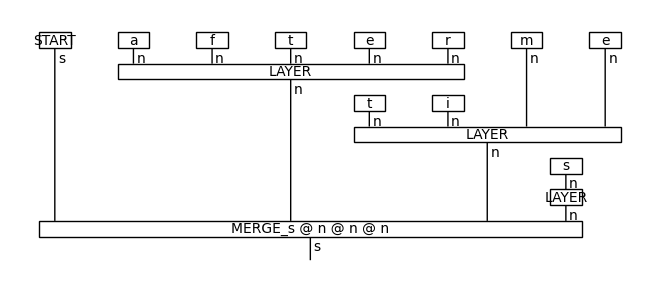

In [36]:
train_diagrams[9].draw()

Translate diagram into quantum circuit

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

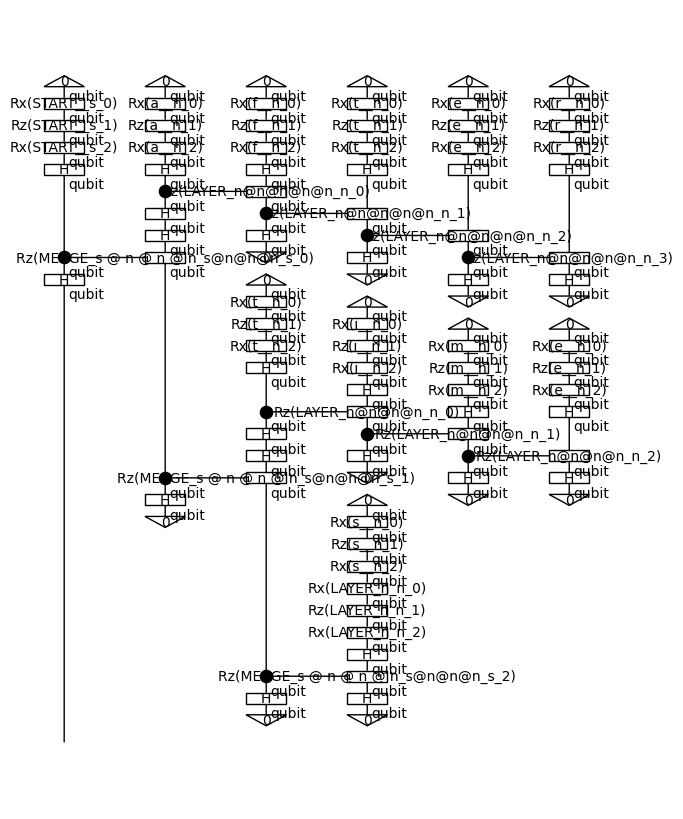

In [37]:
# Create ansatz and convert to tensor diagrams

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = []
i = 0
for diag in train_diagrams:
    print(i)
    train_circuits.append(ansatz(diag)) 
    i += 1

dev_circuits = []
j = 0
for diag in dev_diagrams:
    print(j)
    dev_circuits.append(ansatz(diag)) 
    j += 1

test_circuits = []
k = 0
for diag in test_diagrams:
    print(k)
    test_circuits.append(ansatz(diag)) 
    k += 1

sent_circuits = []
l = 0
for diag in sent_diags:
    print(l)
    sent_circuits.append(ansatz(diag)) 
    l += 1

bpe_circuits = []
l = 0
for diag in bpe_diags:
    print(l)
    bpe_circuits.append(ansatz(diag)) 
    l += 1

morph_circuits = []
l = 0
for diag in morph_diags:
    print(l)
    morph_circuits.append(ansatz(diag)) 
    l += 1


train_circuits[9].draw(figsize=(6, 8))

In [38]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = train_circuits[9].to_tk()
render_circuit_jupyter(tket_circuit)

Parametrise

In [39]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits + test_circuits + sent_circuits + bpe_circuits + morph_circuits

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [40]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss(use_jax=True)

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [41]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [42]:
print(len(dev_circuits))
print(len(labels_dev))

78
78


In [43]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            labels,
            batch_size=BATCH_SIZE)

print(len(dev_circuits))
print(len(labels_dev))

val_dataset = Dataset(dev_circuits, labels_dev, shuffle=False)

78
78


In [44]:
trainer.fit(train_dataset, val_dataset, log_interval=1)

Epoch 1:    train/loss: 0.9669   valid/loss: 0.6996   train/acc: 0.5000   valid/acc: 0.5833
Epoch 2:    train/loss: 0.7950   valid/loss: 0.7761   train/acc: 0.5262   valid/acc: 0.5705
Epoch 3:    train/loss: 0.8378   valid/loss: 0.7736   train/acc: 0.5392   valid/acc: 0.5513
Epoch 4:    train/loss: 1.0049   valid/loss: 0.7870   train/acc: 0.5200   valid/acc: 0.5769
Epoch 5:    train/loss: 0.7933   valid/loss: 0.7251   train/acc: 0.5192   valid/acc: 0.5513
Epoch 6:    train/loss: 0.7752   valid/loss: 0.7375   train/acc: 0.5138   valid/acc: 0.5000
Epoch 7:    train/loss: 0.7806   valid/loss: 0.6775   train/acc: 0.5215   valid/acc: 0.5128
Epoch 8:    train/loss: 0.7470   valid/loss: 0.6864   train/acc: 0.4854   valid/acc: 0.5256
Epoch 9:    train/loss: 0.7337   valid/loss: 0.6982   train/acc: 0.5077   valid/acc: 0.4359
Epoch 10:   train/loss: 0.7708   valid/loss: 0.6981   train/acc: 0.4915   valid/acc: 0.5513
Epoch 11:   train/loss: 0.7403   valid/loss: 0.6587   train/acc: 0.4808   valid/

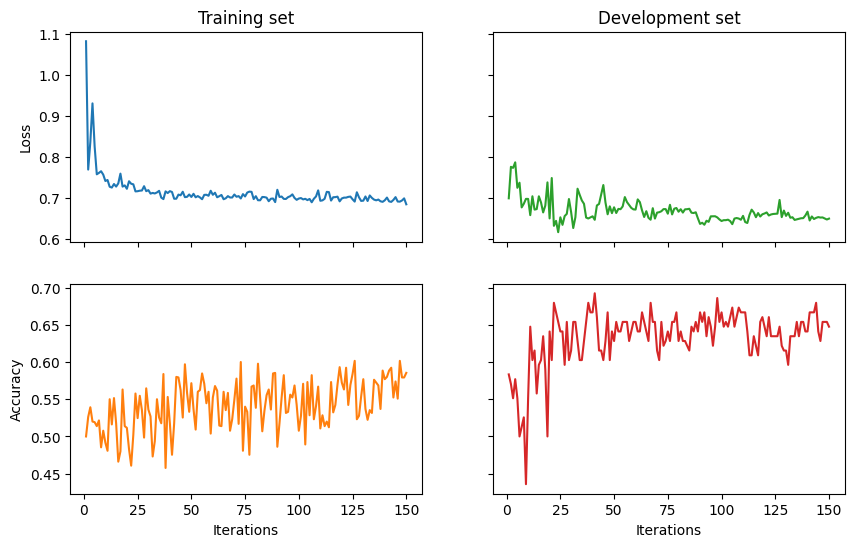

In [45]:
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))



In [46]:
test_acc = acc(model(test_circuits), np.array(labels_test))
print('Test accuracy:', test_acc)

Test accuracy: 0.6117647


Use the model to select tokenization

In [47]:
# Source HW #1 Morphological Segmentation
def evaluate(gold, pred):

  tp = 0
  fp = 0
  fn = 0

  for g, p in zip(gold, pred):
    g_bag = g.strip().split(" ")
    p_bag = p.strip().split(" ")

    tp += sum([1 for i in p_bag if i in g_bag])
    fp += sum([1 for i in p_bag if not i in g_bag])
    fn += sum([1 for i in g_bag if not i in p_bag])

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  if precision == 0 or recall == 0:
    f1 = 0
  else:
    f1 = 2 / ((1/precision) + (1/recall))

  return {
      "f1": f1,
      "precision": precision,
      "recall": recall,
  }


Get the final predictions for the quantum model

In [51]:
print(len(bpe_circuits))
print(len(sent_circuits))
print(len(morph_circuits))

bpe_avgs = []
sent_avgs = []
morph_avgs = []

preds_final = []

counts = {
    "bpe": 0,
    "sent": 0,
    "morph": 0
}

for i in range(len(bpe_circuits)):
    bpe_avg = []
    sent_avg = []
    morph_avg = []
    
    # Run through model 100 times and get average score that model is correct model

    for j in range(100):
        bpe_mm = model([bpe_circuits[i]])
        bpe_avg.append(bpe_mm[0][0])
        sent_mm = model([sent_circuits[i]])
        sent_avg.append(sent_mm[0][0])
        morph_mm = model([morph_circuits[i]])
        morph_avg.append(morph_mm[0][0])
    
    avg_sent = round(sum(sent_avg)/len(sent_avg), 3)
    avg_morph = round(sum(morph_avg)/len(morph_avg), 3)
    avg_bpe = round(sum(bpe_avg)/len(bpe_avg), 3)

    bpe_avgs.append(avg_bpe)
    sent_avgs.append(avg_sent)
    morph_avgs.append(avg_morph)

    # Return the tokenization with the highest score
    if avg_sent >= avg_morph and avg_sent >= avg_bpe:
        preds_final.append(preds_sent[i])
        counts["sent"] += 1
    elif avg_morph >= avg_sent and avg_morph >= avg_bpe:
        preds_final.append(preds_morph[i])
        counts["morph"] += 1
    else:
        preds_final.append(preds_bpe[i])
        counts["bpe"] += 1


85
85
85


In [52]:
print(counts)

{'bpe': 0, 'sent': 50, 'morph': 35}


In [49]:
print(preds_final[:10])

['biclosed', 'p l ur ifi ed', 'ex i g en d a ri es', 'anticultures', 'pseudomythological', 's c or eth', 'cantaloupey', 'appression', 'divulsing', 'b i f a ce t ed']


In [50]:
print(evaluate(clean_test, preds_final))

{'f1': 0.14953271028037382, 'precision': 0.11869436201780416, 'recall': 0.20202020202020202}
